The dataset contains the following variables:   
    
name: the name of the meteorite      
id: a unique identifier for the meteorite         
nametype:      
    one of:          
    -- valid: a typical meteorite           
    -- relict: a meteorite that has been highly degraded by weather on Earth     
recclass: the class of the meteorite.  There are a large number of classes and they are based on physical and chemical makeup as well as many other characterisitics.    
mass: the mass in grams   
fall: whether the meteorite was seen falling, or was discovered after its impact; one of: 
      -- Fell: the meteorite's fall was observed              
      -- Found: the meteorite's fall was not observed                       
year: the year the meteorite was discovered, whether found or fell 
reclat: the latitude of the meteorite's landing   
reclong: the longitude of the meteorite's landing    
GeoLocation: a parentheses-enclose, comma-separated tuple that combines reclat and reclong   

information provided with data:
some entries contain incorrect date information
some geographical location data entered as 00.00000 - many were discovered in antarcitica but exact coordinates were not given. Should probably be treated as NA


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx
import reverse_geocoder as rg
from matplotlib.animation import FuncAnimation
import geopandas
import pylab
import pytz

# import seaborn as sns

# import geoplot



In [2]:
# starting over with Pandas

meteor_data = pd.read_csv('data/meteorite-landings.csv')

In [3]:
meteor_data.head(2)

name  id nametype recclass   mass  fall    year    reclat   reclong  \
0  Aachen   1    Valid       L5   21.0  Fell  1880.0  50.77500   6.08333   
1  Aarhus   2    Valid       H6  720.0  Fell  1951.0  56.18333  10.23333   

              GeoLocation  
0   (50.775000, 6.083330)  
1  (56.183330, 10.233330)

Start data cleaning by looking for nulls     
How many? 7315 in location data 288 in year and 131 in mass. 

In [4]:
#meteor_data.isnull() # start cleaning by looking for nulls
meteor_data.isnull().sum() 
# how many? 7315 within location - was not reported 

name              0
id                0
nametype          0
recclass          0
mass            131
fall              0
year            288
reclat         7315
reclong        7315
GeoLocation    7315
dtype: int64

In [5]:
meteorclean = meteor_data.copy() 
meteorclean.dropna(inplace=True)
meteorclean.isnull().sum() # make sure no null

name           0
id             0
nametype       0
recclass       0
mass           0
fall           0
year           0
reclat         0
reclong        0
GeoLocation    0
dtype: int64

In [6]:
meteorclean['year'] = meteorclean['year'].astype({'year': int})# fix year datatype
meteorclean=meteorclean.sort_values(by=['year'])
#set to 50 year span
meteorclean.drop(meteorclean[meteorclean['year'] < 1976].index, inplace=True) 
meteorclean.drop(meteorclean[meteorclean['year'] > 2016].index, inplace=True)
meteorclean.drop(meteorclean[meteorclean['mass'] == 0.0000].index, inplace=True)
meteorclean.drop(meteorclean[meteorclean['GeoLocation']=='(0.000000, 0.000000)'].index, inplace=True)
meteorclean.reset_index(inplace=True)
# Shrinked the size and trimmed the GeoLocation Data input as 0.00000 (data set explanation recommended treat as NA)

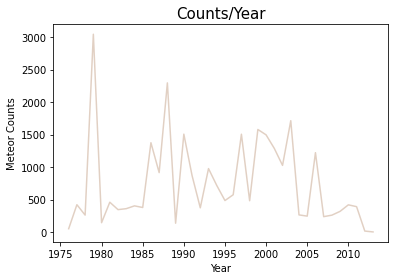

In [8]:
# quick graph of count/year
counts = meteorclean['year'].groupby([meteorclean.year]).agg('count')
fig, ax = plt.subplots()
ax.set_title('Counts/Year', fontsize=15)
ax.set_xlabel('Year')
ax.set_ylabel('Meteor Counts')
ax.plot(counts, color='saddlebrown', alpha=.25)

28519

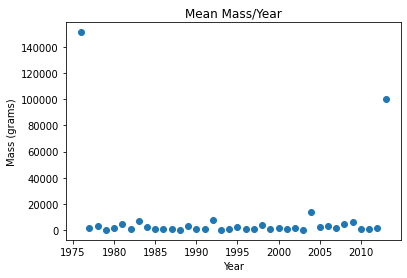

In [9]:

msize = meteorclean.groupby('year')['mass'].mean()


fig, ax = plt.subplots()
ax.set_title('Mean Mass/Year')
ax.set_xlabel('Year')
ax.set_ylabel('Mass (grams)')
ax.scatter(x =msize.index, y=msize.values)

# Stats for Mass
mass_median = meteorclean['mass'].median()
mass_25 = meteorclean['mass'].quantile(0.25)
mass_75 = meteorclean['mass'].quantile(0.75)
mass_max= meteorclean['mass'].max()
mass_min= meteorclean['mass'].min()




In [10]:

# all unique
areacount = meteorclean.groupby('GeoLocation')['name'].agg('count').sort_values


<ipython-input-11-aed33f07f7ae>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  labels = ax.set_xticklabels(y, rotation=90)


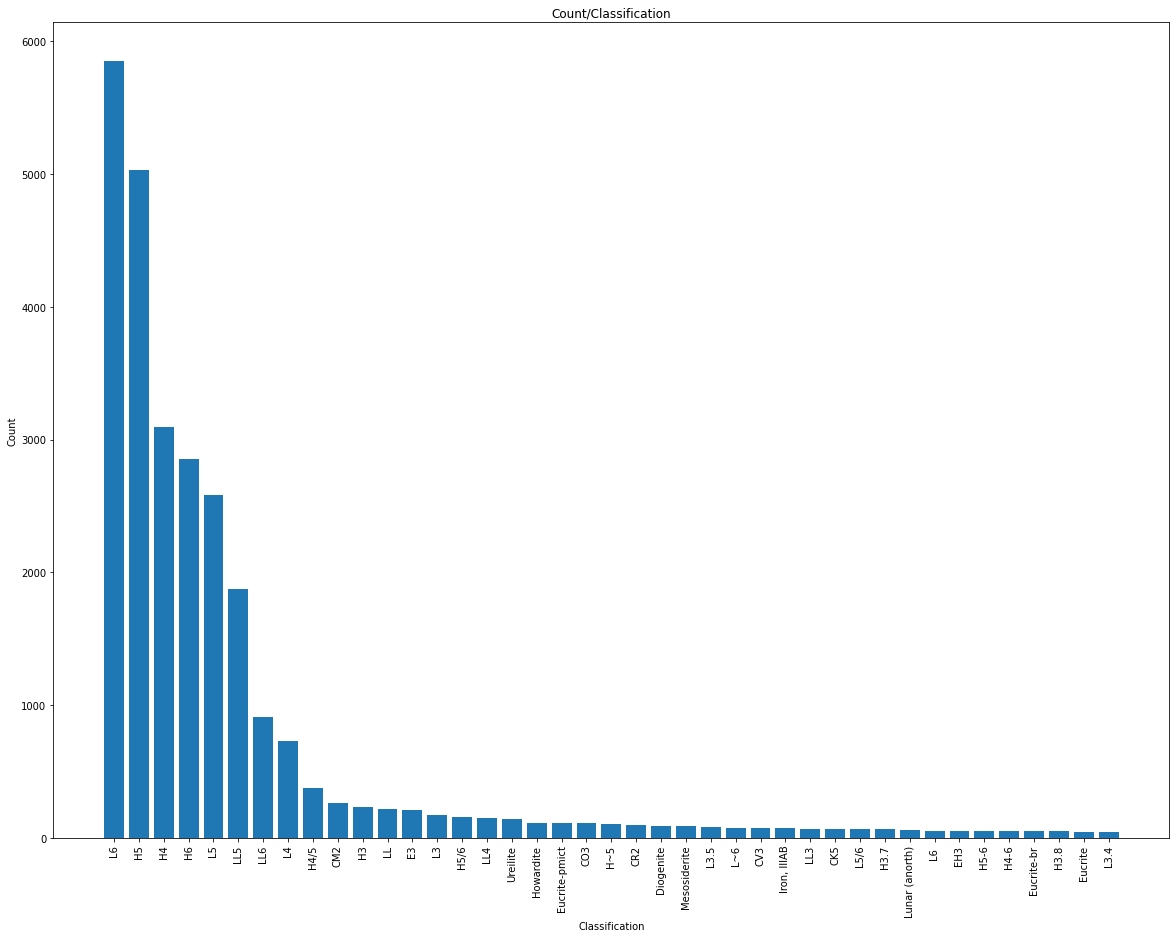

In [11]:
recclasscount = meteorclean['recclass'].groupby([meteorclean.recclass]).agg('count').sort_values(ascending=False).head(41)
y= recclasscount.index
x = recclasscount.values
fig, ax = plt.subplots(figsize=(20, 15))
ax.set_title('Count/Classification')
ax.set_xlabel('Classification')
ax.set_ylabel('Count')
ax.bar(y,x)
counts = ('count')
labels = ax.set_xticklabels(y, rotation=90)




In [12]:
vals = meteorclean['mass'].sort_values(ascending=False)
vals.head(5)

32       4000000.0
25180    3000000.0
26626    3000000.0
10       2753000.0
13076    2000000.0
Name: mass, dtype: float64

In [31]:
# create list of dictionaries  with country information
geoloc = []
for lat in meteorclean['reclat']:
    for long in meteorclean['reclong']:
        tup =(lat, long)

    geoloc.append(tup)

coordinates = rg.search(geoloc)
#create dataframe with location information
coord = []

for i in range(len(coordinates)):
    # for k in coordinates[i]:
    coord.append((coordinates[i]['lat'], coordinates[i]['lon'], coordinates[i]['cc'],pytz.country_names[(coordinates[i]['cc'])]))

locdf = pd.DataFrame(coord, columns = ['reclat', 'reclong', 'cc', 'location'])


In [44]:
df= meteorclean.copy()
if str(meteorclean['reclat']) in str(locdf['reclat']) & str(meteorclean['reclong']) in str(locdf['reclong']):
    df['location'] = locdf['location']

TypeError: unsupported operand type(s) for &: 'str' and 'str'

In [14]:
locdf

reclat   reclong  cc      location
0       37.38338  60.50545  TM  Turkmenistan
1       37.38338  60.50545  TM  Turkmenistan
2       37.38338  60.50545  TM  Turkmenistan
3       37.38338  60.50545  TM  Turkmenistan
4       37.38338  60.50545  TM  Turkmenistan
...          ...       ...  ..           ...
171109    54.801   61.2989  RU        Russia
171110    54.801   61.2989  RU        Russia
171111    54.801   61.2989  RU        Russia
171112    54.801   61.2989  RU        Russia
171113    54.801   61.2989  RU        Russia

[171114 rows x 4 columns]

In [38]:
# meteorclean= meteorclean.assign(location=meteorclean.apply('location', axis=1))

# meteorclean['location'] = locdf['location'].groupby([meteorclean.])



# counts = meteorclean['year'].groupby([meteorclean.year]).agg('count')
def location(x):
  if (x['reclat'] == locdf['reclat']) & (x['reclong'] == locdf['reclong']):
        return "Test"
location(meteorclean)
# meteorclean= meteorclean.assign(location=meteorclean.apply('location', axis=1))


# def location(x):
#     if (x['reclat'] >37) and (x['reclat'] <66) and (x['reclong'] >-25) and (x['reclong']< 26):
#         return 'Europe'
#     elif (x['reclat'] >42) and (x['reclat'] <66) and (x['reclong'] >26) and (x['reclong']< 50):
#         return 'Europe'
#     elif (x['reclat'] >8) and (x['reclat'] <30) and (x['reclong'] >70) and (x['reclong']< 88):
#         return 'India'
#     elif (x['reclat'] >29) and (x['reclat'] <41) and (x['reclong'] >128) and (x['reclong']<145):
#         return 'Japan'    
#     elif (x['reclat'] >20) and (x['reclat'] <120) and (x['reclong'] >100) and (x['reclong']<125):
#         return 'China'
#     elif (x['reclat'] >-36) and (x['reclat'] <31) and (x['reclong'] >-17) and (x['reclong']<44):
#         return 'Africa'            
#     elif (x['reclat'] >25) and (x['reclat'] <49) and (x['reclong'] >-125) and (x['reclong']<-67):
#         return 'USA'    
#     elif (x['reclat'] >-56) and (x['reclat'] <12) and (x['reclong'] >-81) and (x['reclong']<-34):
#         return 'SouthAmerica'
#     elif (x['reclat'] >-35) and (x['reclat'] <-25) and (x['reclong'] >110) and (x['reclong']<155):
#         return 'Australia'
#     elif (x['reclat'] >-90) and (x['reclat'] <-60) and (x['reclong'] >-180) and (x['reclong']<180):
#         return 'Antarctica'   
#     elif (x['reclat'] >-45) and (x['reclat'] <-33) and (x['reclong'] >169) and (x['reclong']<174):
#         return 'New Zealand'  
#     elif (x['reclat'] >18) and (x['reclat'] <32) and (x['reclong'] >-41) and (x['reclong']<55):
#         return 'Middle East'       
#     else:
#         return 'Blacksite'

# meteorclean= meteorclean.assign(location=meteorclean.apply(location, axis=1))

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
x_data = []
y_data = []
fig, ax = plt.subplots()
ax.set_xlim(0,105)
ax.set_ylim(0,12)
line, = ax.plot(0,0)

def animation_frame(i):
    x_data.append(i * 10)
    y_data.append(i)

    line.set_xdata(x_data)
    line.set_ydata(y_data)
    return line, 

animation =FuncAnimation(fig, func=animation_frame, frames=np.arange(0,10,.01), interval =10)

plt.show()


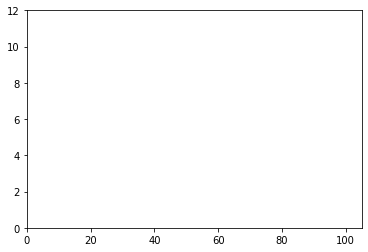

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

x_data = []
y_data = []

fig, ax = plt.subplots()
ax.set_xlim(0, 105)
ax.set_ylim(0, 12)
line, = ax.plot(0, 0)

def animation_frame(i):
	x_data.append(i * 10)
	y_data.append(i)

	line.set_xdata(x_data)
	line.set_ydata(y_data)
	return line, 

animation = FuncAnimation(fig, func=animation_frame, frames=np.arange(0, 10, 0.1), interval= 50)
plt.show()

In [23]:
geoloc = []
for lat in meteorclean['reclat']:
    for long in meteorclean['reclong']:
        tup =(lat, long)

    geoloc.append(tup)

coordinates = rg.search(geoloc)

# >>> import reverse_geocoder as rg
# >>> coordinates = (51.5214588,-0.1729636),(9.936033, 76.259952),(37.38605,-122.08385)
# >>> rg.search(coordinates)



Loading formatted geocoded file...


In [24]:
# loccount= meteorclean['location'].groupby([meteorclean.location]).agg('count')
coordinates[0:2], type(coordinates[0])
# dataList = [{'a': 1}, {'b': 3}, {'c': 5}]
# for index in range(len(dataList)):
#     for key in dataList[index]:
#         print(dataList[index][key])



([{'lat': '37.38338',
   'lon': '60.50545',
   'name': 'Tejen',
   'admin1': 'Ahal',
   'admin2': '',
   'cc': 'TM'},
  {'lat': '37.59378',
   'lon': '61.83031',
   'name': 'Mary',
   'admin1': 'Mary',
   'admin2': '',
   'cc': 'TM'}],
 dict)

In [70]:
coord = []

for i in range(len(coordinates)):
    for k in coordinates[i]:
        coord.append((coordinates[i]['lat'], coordinates[i]['lon'], coordinates[i]['cc'],pytz.country_names[(coordinates[i]['cc'])]))



In [75]:
# data = [['tom', 10], ['nick', 15], ['juli', 14]]
  
# # Create the pandas DataFrame
# df = pd.DataFrame(data, columns = ['Name', 'Age'])
  
df = pd.DataFrame(coord, columns = ['lat', 'log', 'cc', 'location'])


In [76]:
df

lat       log  cc      location
0       37.38338  60.50545  TM  Turkmenistan
1       37.38338  60.50545  TM  Turkmenistan
2       37.38338  60.50545  TM  Turkmenistan
3       37.38338  60.50545  TM  Turkmenistan
4       37.38338  60.50545  TM  Turkmenistan
...          ...       ...  ..           ...
171109    54.801   61.2989  RU        Russia
171110    54.801   61.2989  RU        Russia
171111    54.801   61.2989  RU        Russia
171112    54.801   61.2989  RU        Russia
171113    54.801   61.2989  RU        Russia

[171114 rows x 4 columns]

In [27]:
meteorclean= meteorclean.assign(location=meteorclean.apply(location, axis=1))

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [104]:
loccount= meteorclean['location'].groupby([meteorclean.location]).agg('count')
loccount, sum(loccount)    

(location
 Africa           2351
 Antarctica      21325
 Australia         383
 Blacksite        1648
 China              41
 Europe             72
 India              18
 Japan              12
 Middle East      1579
 New Zealand         1
 SouthAmerica      405
 USA               684
 Name: location, dtype: int64,
 28519)

In [74]:
meteorclean.loc[meteorclean['location'] == 'Antarctica']

index                     name     id nametype      recclass      mass  \
7      26184       Mount Baldr A76001  16764    Valid            H6    4108.0   
8      26185       Mount Baldr A76002  16765    Valid            H6   13773.0   
30      2421       Allan Hills A76002   1309    Valid  Iron, IAB-MG    1510.0   
34      2428       Allan Hills A76009   1316    Valid            L6  407000.0   
39      2420       Allan Hills A76001   1308    Valid            L6   20151.0   
...      ...                      ...    ...      ...           ...       ...   
28313  12050  Frontier Mountain 10018  54801    Valid            H6       2.6   
28314  12049  Frontier Mountain 10015  54800    Valid            H4       3.5   
28315  12048  Frontier Mountain 10003  54844    Valid            L3       2.9   
28341  12068  Frontier Mountain 10083  54879    Valid           LL3       5.9   
28380  12047  Frontier Mountain 10002  54799    Valid            H6       2.7   

        fall  year    reclat    reclong               GeoLocation    location  
7      Found  1976 -77.58389  160.32639  (-77.583890, 160.326390)  Antarctica  
8      Found  1976 -77.58389  160.37361  (-77.583890, 160.373610)  Antarctica  
30     Found  1976 -76.71667  159.66667  (-76.716670, 159.666670)  Antarctica  
34     Found  1976 -76.71667  159.66667  (-76.716670, 159.666670)  Antarctica  
39     Found  1976 -76.75000  159.33333  (-76.750000, 159.333330)  Antarctica  
...      ...   ...       ...        ...                       ...         ...  
28313  Found  2011 -72.95205  160.48720  (-72.952050, 160.487200)  Antarctica  
28314  Found  2011 -72.95215  160.50155  (-72.952150, 160.501550)  Antarctica  
28315  Found  2011 -72.95268  160.48213  (-72.952680, 160.482130)  Antarctica  
28341  Found  2011 -72.95128  160.51542  (-72.951280, 160.515420)  Antarctica  
28380  Found  2011 -72.95290  160.47965  (-72.952900, 160.479650)  Antarctica  

[21325 rows x 12 columns]

In [22]:
H4H6 = meteorclean[(meteorclean.location == 'Antarctica')]
H4H6nums = meteorclean['recclass'].groupby([meteorclean.recclass]).agg('count').sort_values(ascending=False).head(20)
H4H6nums, sum(H4H6nums)


(recclass
 L6               5852
 H5               5034
 H4               3094
 H6               2853
 L5               2579
 LL5              1872
 LL6               908
 L4                727
 H4/5              372
 CM2               260
 H3                231
 LL                216
 E3                205
 L3                168
 H5/6              154
 LL4               147
 Ureilite          143
 Howardite         109
 Eucrite-pmict     107
 CO3               107
 Name: recclass, dtype: int64,
 25138)

# Nicer Data Visualizations

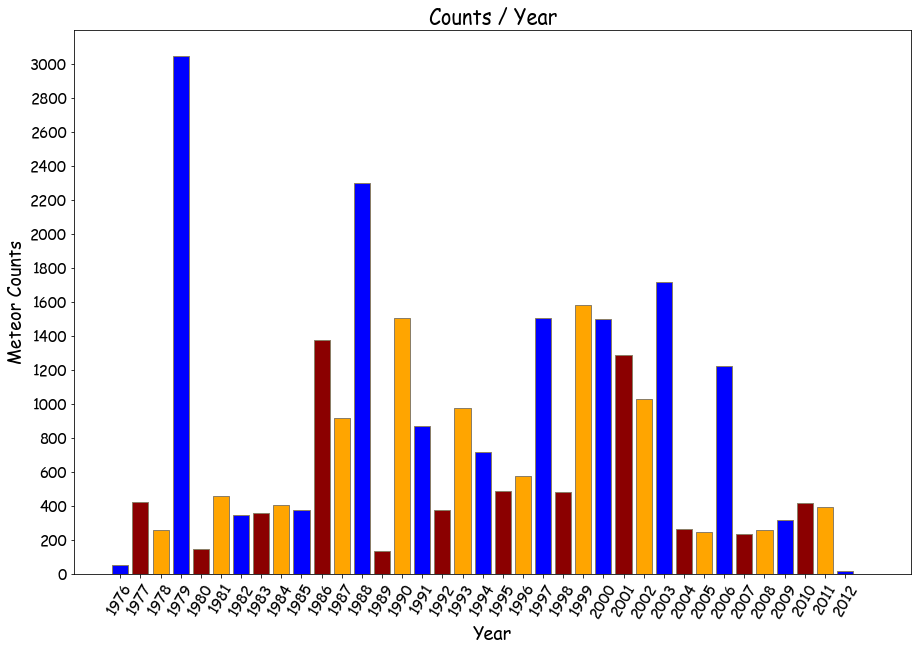

In [114]:
counts = meteorclean['year'].groupby([meteorclean.year]).agg('count')

# fig, ax = plt.subplots()
# plt.yticks(np.arange(0,3500, 200),fontsize=15)
# plt.xticks(np.arange(1976, 2013, 1), rotation=60, fontsize=15)
# fig.set_size_inches(15,10)
# ax.set_title('Counts / Year', fontsize=20)
# ax.set_xlabel('Year', fontsize=18)   
# ax.set_ylabel('Meteor Counts',fontsize=18)
# ax.bar(x=counts.index, height=counts.values, edgecolor='#8B7E66', color= ('blue', 'darkred' , 'orange'),align='center')
# plt.rcParams['font.family'] = 'fantasy'
# # plt.show()
# # plt.savefig('data/Counts_Year.png')

Text(0.37, 0.8, 'Max (million)4.0, Mean 1654.36, Min 0.01')

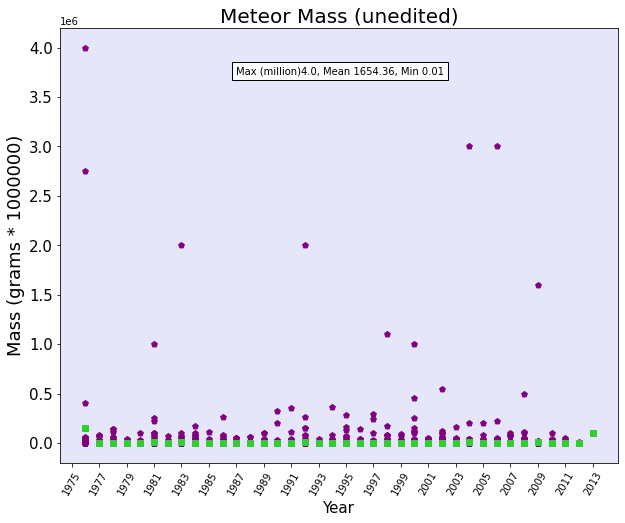

In [85]:
msize = meteorclean[['year', 'mass']].sort_values(['mass'])
msizeavg = msize.groupby('year')['mass'].mean()
# Compute some stats
mass_median = meteorclean['mass'].median()
mass_25 = meteorclean['mass'].quantile(0.25)
mass_75 = meteorclean['mass'].quantile(0.75)
mass_max= meteorclean['mass'].max()
mass_min= meteorclean['mass'].min()
mass_mean=meteorclean['mass'].mean()

# plt.rcParams['font.family'] = "Helvetica"



fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
ax.set_facecolor('lavender')
fig.set_size_inches(10,8)
ax.scatter(x=msize['year'], y=msize['mass'], marker='p',color='purple')
ax.scatter(x=msizeavg.index, y=msizeavg, marker='s', color='limegreen')
# plt.annotate((mass_max, mass_mean, mass_min), ('Max', 'Mean', 'Min'))
ax.set_title('Meteor Mass (unedited)', fontsize=20)
ax.set_xlabel('Year', fontsize=15)   
ax.set_ylabel('Mass (grams * 1000000)',fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(np.arange(1975, 2015, 2),rotation=60)
fig.text(.37, .80, f'Max (million){mass_max/1000000}, Mean {round(mass_mean, 2)}, Min {round(mass_min,2)}', bbox=dict(facecolor='white', alpha=1))
# plt.show()
# plt.savefig('data/Meteor_Mass_All.png')

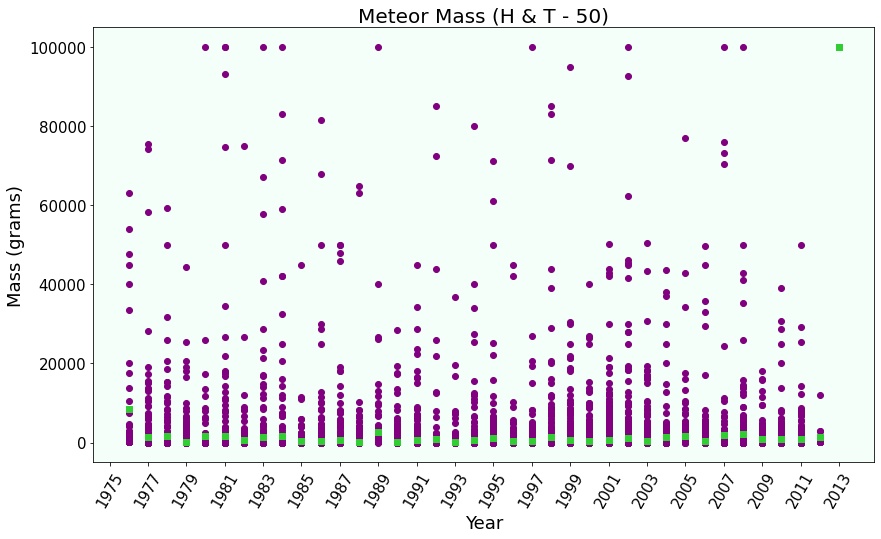

In [89]:
#Dropping last n rows using drop
msize_trim = msize.copy()
msize_trim = msize_trim.tail(-50)
msize_trim = msize_trim.head(-50)
m_trimavg = msize_trim.groupby('year')['mass'].mean()

fig, ax = plt.subplots()
fig.set_size_inches(14,8)



fig.patch.set_facecolor('white')
ax.set_facecolor('mintcream')
ax.scatter(x=msize_trim['year'], y=msize_trim['mass'], color='purple')
ax.scatter(x=m_trimavg.index, y=m_trimavg, marker='s', color='limegreen')
ax.set_title('Meteor Mass (H & T - 50)', fontsize=20)
ax.set_xlabel('Year', fontsize=10)   
plt.yticks(fontsize=15)
plt.xticks(np.arange(1975, 2015, 2),size=15, rotation=60)

ax.set_xlabel('Year', fontsize=18)   
ax.set_ylabel('Mass (grams)',fontsize=18)



# plt.show()
# plt.savefig('data/Meteor_Mass_Minus50.png')

In [42]:
msize_trim.count()

year    28439
mass    28439
dtype: int64

In [ ]:
# #Dropping last n rows using drop
# msize_trim = msize.copy()
# msize_trim = msize_trim.tail(-10).sort_values('year', ascending=True)
# msize_trim = msize_trim.head(-10).sort_values('year', ascending=True)
# m_trimavg = msize_trim.groupby('year')['mass'].mean()

# fig, ax = plt.subplots(figsize=(14, 8))

# sns.set_color_codes("pastel")
# sns.barplot(x=msize_trim['year'], y=msize_trim['mass'], label='Mass Range')




# ax.set_title('Meteor Mass (H & T - 10)', fontsize=20)

# sns.set_theme(style = 'whitegrid')

# # ax.set_xticklabels('Years', rotation=80)
# sns.set_color_codes('muted')


# # # sns.set_color_codes('dark')
# # sns.barplot(x=msize_trim['year'], y=msize_trim.mean().sort_index( ascending=True))

# ax.legend(ncol=2, loc="lower right", frameon=True)
# ax.set(ylim=(0.000, 380000), ylabel='Mass (grams)')
# sns.despine(left=True, bottom=True)
# sns.set(font_scale = 10)
# sns.set_style("ticks",{"xtick.major.size":10,
# "ytick.major.size":10})
# # ax.scatter(x=msize_trim['year'], y=msize_trim['mass'], color='blue')
# # ax.scatter(x =m_trimavg.index, y=m_trimavg.values, marker='s', color='red')
# # ax.legend(loc=1, prop={'size':15})
# # ax.set_title('Meteor Mass (H & T - 10)', fontsize=20)
# # ax.set_xlabel('Year', fontsize=18)   
# # ax.set_ylabel('Mass (grams)',fontsize=18)
# # plt.yticks(fontsize=15)

# plt.show()

# Types visual 

In [76]:
# recclasscount = meteorclean['recclass'].groupby([meteorclean.recclass]).agg('count').sort_values(ascending=False).head(50)
y= recclasscount.index
x = recclasscount.values


fig, ax = plt.subplots(figsize=(18, 12))
plt.rcParams['font.family'] = "Helvetica"
fig.patch.set_facecolor('lightcyan')
ax.set_title('Count/Classification', fontsize=25)
ax.set_xlabel('Classification', fontsize=18)
ax.set_ylabel('Count', fontsize=18)
ax.bar(y,x , color=('steelblue', 'lightblue'))
counts = ('count')
labels = ax.set_xticklabels(y, rotation=80, fontsize=15)
plt.yticks(np.arange(0,6500, 500),fontsize=15)
fig.text(.75, .5, f'Top 10\n L6 5852\n H5 5034\n H4 3094\n H6 2853\n L5 2579\n LL5 1872\n LL6 908\n L4 727\n H4/5 372\n CM2 260', size=20  , bbox=dict(facecolor='lightcyan', alpha=1))
plt.show()

plt.show( )
# plt.savefig('data/Classification_Breakout.png')



recclasscount = meteorclean.groupby('recclass')['recclass'].agg('count').sort_values(ascending=False)
samp = recclasscount.head(100)
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Count/Classification')
ax.set_xlabel('Classification')
ax.set_ylabel('Count')
ax.plot(samp)
recclasscount.head(50)
labels = ax.set_xticklabels(samp.value_counts().index,rotation=90)

plt.yticks(np.arange(0,6000, 500),fontsize=15)
plt.xticks(np.arange(len(samp)), rotation=60, fontsize=15)
plt.show()

In [60]:
recclasscount.head(10)

recclass
L6      5852
H5      5034
H4      3094
H6      2853
L5      2579
LL5     1872
LL6      908
L4       727
H4/5     372
CM2      260
Name: recclass, dtype: int64

# Map Visual

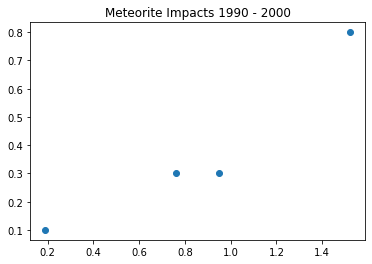

In [18]:
plt.ion()
plt.title("Meteorite Impacts 1990 - 2000")

impacts = [(1994, 0.5, 0.3),(1991, 0.4, 0.3),(1998, 0.1, 0.1),(1992, 0.8, 
0.8)]
lat_lon = [(b, c) for a, b, c in impacts]
x, y = [1.9*a for a, b in lat_lon], [b for a, b in lat_lon]
plt.imread("Equirectangular-projection.jpeg")
plt.scatter(x, y)
plt.show()

In [149]:
import plotly.express as px

plt.figure(figsize=(15,15))


df = meteorclean
fig = px.scatter_geo(meteorclean, 
                    #location="iso_alpha",
                     color="GeoLocation", # which column to use to set the color of markers
                     hover_name="location", # column added to hover information
                     #size="pop", # size of markers
                     #projection="natural earth")
)
# px = meteorclean.plot(figsize=(15,15), kind= 'scatter', x='reclong', y='reclat')


KeyboardInterrupt: 

In [143]:
meteorclean

index                   name     id nametype     recclass      mass  \
0      16359           Haviland (b)  11861    Valid           H5    2092.0   
1      21775                  Luray  14758    Valid           OC     861.0   
2      22903               Mar'inka  15423    Valid   Iron, IIAB     144.0   
3      16316       Hangman Crossing  11816    Valid           H4    1300.0   
4      38329              Wimberley  24282    Valid  Iron, IIIAB    7800.0   
...      ...                    ...    ...      ...          ...       ...   
28514    965          Sutter's Mill  55529    Valid            C     992.5   
28515  17245  Jiddat al Harasis 799  57428    Valid          LL6     212.0   
28516  17252           Johannesburg  55765    Valid           H4      63.0   
28517  21698        Los Vientos 028  57338    Valid          H~5   12110.0   
28518    194            Chelyabinsk  57165    Valid          LL5  100000.0   

        fall  year    reclat    reclong               GeoLocation  \
0      Found  1976  37.59667  -99.12500   (37.596670, -99.125000)   
1      Found  1976  39.11667  -98.68333   (39.116670, -98.683330)   
2      Found  1976  47.90000   37.50000    (47.900000, 37.500000)   
3      Found  1976  38.91972  -85.94722   (38.919720, -85.947220)   
4      Found  1976  29.96667  -98.11667   (29.966670, -98.116670)   
...      ...   ...       ...        ...                       ...   
28514   Fell  2012  38.80389 -120.90806  (38.803890, -120.908060)   
28515  Found  2012  19.77278   56.38982    (19.772780, 56.389820)   
28516  Found  2012  35.37788 -117.63728  (35.377880, -117.637280)   
28517  Found  2012 -24.68333  -69.76667  (-24.683330, -69.766670)   
28518   Fell  2013  54.81667   61.11667    (54.816670, 61.116670)   

           location  
0               USA  
1               USA  
2            Europe  
3               USA  
4               USA  
...             ...  
28514           USA  
28515     Blacksite  
28516           USA  
28517  SouthAmerica  
28518     Blacksite  

[28519 rows x 12 columns]

In [165]:
import importlib
importlib.import_mudule('mpl_toolkits')
import mpl_toolkits
from mpl_toolkits.basemap import Basemap
# Make the background map
plt.figure(figsize=(24,18))
m=Basemap(llcrnrlon=-180, llcrnrlat=-90,urcrnrlon=180,urcrnrlat=90)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")

m.plot(meteorclean['reclong'], meteorclean['reclat'], linestyle='none', marker='o', ms=1, color='red', label='observed')
m.plot(found['reclong'], found['reclat'], linestyle='none', marker='o', ms=1, color='black', label='found')
plt.legend(loc=6, prop={'size': 30}, markerscale=8)
plt.title('Geographic Distribution of meteorites', fontsize=25)

AttributeError: module 'importlib' has no attribute 'import_mudule'

In [19]:
g <- ggplot(data = meteorclean, aes(x = reclong, y = reclat)) +
    borders(database = 'world', fill = "white") +
    geom_point(aes(colour = year), alpha = 0.2, size = .3) +
    scale_colour_gradient(low = 'yellow', high = 'salmon')



SyntaxError: positional argument follows keyword argument (<ipython-input-19-ff4a8fd52e72>, line 1)

In [20]:
from mpl_toolkits.basemap import Basemap
# Extract the data we're interested in
lat = meteorclean['reclat'].values
lon = meteorclea['reclong'].values

m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
fig = plt.figure(figsize=(12,10))

x,y = m(lon,lat)

plt.title("Locations of meteors (red)")
m.plot(x, y, "o", markersize = 5, color = 'red')

m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='coral',lake_color='aqua')
m.drawmapboundary()
m.drawcountries()
plt.show()

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [21]:
fig = px.scatter_geo(meteorclean, locations="iso_alpha",
                     color="continent", # which column to use to set the color of markers
                     hover_name="country", # column added to hover information
                     
                     projection="natural earth")

NameError: name 'px' is not defined

In [ ]:
# Simple location plot

img=plt.imread("Equirectangular-projection.jpeg")
# plt.figure(figsize=(15,15))
fig, ax = plt.subplots(figsize=(30,30))
# ax = meteorclean.plot(figsize=(15,15), kind= 'scatter', )
# ax.scatter(x=meteorclean['reclong'], y=meteorclean['reclat'], color='red')
ax.scatter(meteorclean['GeoLocation'], color='red')
# ax.imshow(img)
plt.xticks(np.arange(-180, 180, 90),rotation=60)
plt.yticks(np.arange(-90, 90, 30),rotation=60)
ax.imshow(img, extent=[-5, 80, -5, 30])
# ax.scatter(TMIN, PRCP, color="#ebb734")
plt.show()